# Introduction

You may have noticed that crossmatching takes a long time, even with significantly cut down catalogues.

We've seen this before: **inefficient algorithms**.

The way we've implemented our crossmatcher means that for every object in BSS, we need to calculate distance to every object in SuperCOSMOS. Even our small crossmatching task requires 160 × 500 = 80,000 distance calculations.

With each distance calculation taking a few microseconds, it quickly adds up to seconds or minutes.

Seconds may not seem like much but remember that the full SuperCOSMOS catalogue has 126 million objects, over 250,000 times larger than the truncated version we gave you to work with.

Then, imagine you were trying to crossmatch a catalogue other than AT20G BSS, with a size comparable to SuperCOSMOS. A crossmatching operation like that might take months or years.

We clearly need to be smarter about our choice of algorithm.

In this activity, we’ll look at modifying our previous crossmatcher to show you how easy it is to save computation time.

# A small improvement

In the crossmatcher you developed in the previous activity, it was necessary to convert the RA and declination from degrees to radians so that the trigonometric functions could work with them.

If this conversion occurred in the distance calculation function, then the same coordinates would be converted many times during the crossmatching operation.

In the next problem, we'll ask you to modify your crossmatcher algorithm so that the conversion occurs only once, before any distance calculations. This should save only a small amount of time, but it all adds up in the end.

Since our focus from now on will be improving our algorithm, we'll be using randomly generated catalogues instead of SuperCOSMOS and the AT20G BSS. This lets us see if our changes are improving our algorithm's efficiency in general, instead of just finding something that works for two specific catalogues.

# **Question: Microoptimisation**

Write a crossmatch function for two catalogues to within a maximum radius. The catalogues are 2D NumPy arrays of RA and declination in degrees.

Your function should convert all the coordinates to radians before it starts crossmatching. It should return 3 values:

1. A list of tuples of matched IDs and their distance in degrees;
2. A list of unmatched IDs from the first catalogue;
3. The time taken (in seconds) to run the crossmatcher.

Both catalogues are given as an N×2 NumPy array of floats. Each row contains the coordinates of a single object. The two columns are the RA and declination.

An object's ID is the index of its row, starting at 0. Your function should work with input catalogues with any number of objects.

# ⌛Solution:

In [1]:
# Write your crossmatch function here.
import numpy as np
import time

def angular_dist(r1, d1, r2, d2):
  a = (np.sin(np.abs(d1 - d2)/2))**2
  b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
  d = np.degrees(2*np.arcsin(np.sqrt(a + b)))
  return d

def crossmatch(cat1, cat2, max_dist):
  matches = []
  no_matches = []
  start = time.perf_counter()
  cat1 = np.radians(cat1)
  cat2 = np.radians(cat2)
  id_1 = 0
  for i in cat1:
      best = (0,0,max_dist+1)
      id_2 = 0
      for j in cat2:
        dist = angular_dist(i[0], i[1], j[0], j[1])
        if dist<=best[2]:
          best = (id_1,id_2,dist)
        id_2+=1
      if best[2]<=max_dist:
         matches.append(best)
      else:
         no_matches.append(id_1)
      id_1+=1
  return (matches, no_matches, time.perf_counter() - start)

# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
  # The example in the question
  cat1 = np.array([[180, 30], [45, 10], [300, -45]])
  cat2 = np.array([[180, 32], [55, 10], [302, -44]])
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

  # A function to create a random catalogue of size n
  def create_cat(n):
    ras = np.random.uniform(0, 360, size=(n, 1))
    decs = np.random.uniform(-90, 90, size=(n, 1))
    return np.hstack((ras, decs))

  # Test your function on random inputs
  np.random.seed(0)
  cat1 = create_cat(10)
  cat2 = create_cat(20)
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

matches: [(0, 0, 2.0000000000000027), (2, 2, 1.7420109046547023)]
unmatched: [1]
time taken: 0.00036810399999609444
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.00411188500000037


**Test:**

In [2]:
cat1 = np.array([[180, 30], [45, 10], [300, -45]])
cat2 = np.array([[180, 32], [55, 10], [302, -44]])
matches, no_matches, time = crossmatch(cat1, cat2, 5)
print('matches:', matches)
print('unmatched:', no_matches)
print('time taken:', time_taken)

matches: [(0, 0, 2.0000000000000027), (2, 2, 1.7420109046547023)]
unmatched: [1]
time taken: 0.00411188500000037


# NumPy is fast

Last week, we introduced array operations with NumPy. NumPy performs these calculations much faster than Python's lists and for loops, because NumPy has highly-optimised C and Fortran code specifically for numerical calculations.

The maths functions we used last week (np.sqrt, np.sin, np.cos and np.arcsin) apply to any NumPy number or array. This means you can speed up the part of crossmatch that searches through the second catalogue, by changing this:

In [3]:
min_dist = np.inf
for id2, (ra2, dec2) in enumerate(cat2):
  dist = angular_dist_rad(ra1, dec1, ra2, dec2)
  if dist < min_dist:
    min_dist = dist

NameError: name 'angular_dist_rad' is not defined

to this:

In [ ]:
ra2s = cat2[:, 0]
dec2s = cat2[:, 1]
dists = angular_distance_rad(ra1, dec1, ra2s, dec2s)
min_dist = np.min(dists)

Now the distance calculation happens on all the RAs (ra2s) and declinations (dec2s) of the second catalogue at once. In the next problem, you'll see how much of a speed up this gives us.

# **Question: Vectorisation**

Copy and modify your previous angular_dist and crossmatch in radians functions to calculate the distances to all of the objects in the second catalogue using NumPy arrays.

The return values should behave the same way as the original function, given the same arguments, except time_taken should be noticeably smaller for large catalogues.

# **Hint**
After you create the array of distances from an object in the first catalogue to all objects in the second catalogue, you can use np.argmin to find the array index (also the object ID) of the closest object:

closest_id2 = np.argmin(dists)
closest_id2 = np.argmin(dists)

# ⌛Solution:

In [4]:
# Write your crossmatch function here.
import numpy as np
import time

def angular_dist(r1, d1, r2, d2):
  a = (np.sin(np.abs(d1 - d2)/2))**2
  b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
  d = 2*np.arcsin(np.sqrt(a + b))
  return d

def crossmatch(cat1, cat2, max_dist):
  max_dist = np.radians(max_dist)
  matches = []
  no_matches = []
  start = time.perf_counter()
  cat1 = np.radians(cat1)
  cat2 = np.radians(cat2)
  ra2s = cat2[:, 0]
  dec2s = cat2[:, 1]
  id_1 = 0
  for i in cat1:
      best = (0, 0, max_dist+1)
      dists = angular_dist(i[0], i[1], ra2s, dec2s)
      min_dist = np.min(dists)
      id_2 = np.argmin(dists)
      best = (id_1, id_2, min_dist)

      if best[2]<=max_dist:
         matches.append(best)
      else:
         no_matches.append(id_1)
      id_1+=1
  return (matches, no_matches, time.perf_counter() - start)

# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
  # The example in the question
  ra1, dec1 = np.radians([180, 30])
  cat2 = [[180, 32], [55, 10], [302, -44]]
  cat2 = np.radians(cat2)
  ra2s, dec2s = cat2[:,0], cat2[:,1]
  dists = angular_dist(ra1, dec1, ra2s, dec2s)
  print(np.degrees(dists))

  cat1 = np.array([[180, 30], [45, 10], [300, -45]])
  cat2 = np.array([[180, 32], [55, 10], [302, -44]])
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

  # A function to create a random catalogue of size n
  def create_cat(n):
    ras = np.random.uniform(0, 360, size=(n, 1))
    decs = np.random.uniform(-90, 90, size=(n, 1))
    return np.hstack((ras, decs))

  # Test your function on random inputs
  np.random.seed(0)
  cat1 = create_cat(10)
  cat2 = create_cat(20)
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

[  2.         113.72587199 132.64478705]
matches: [(0, 0, 0.03490658503988664), (2, 2, 0.03040382589186957)]
unmatched: [1]
time taken: 0.0005834799999888673
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.0006752700000163259


# **Test**:

In [5]:
ra1, dec1 = np.radians([180, 30])
cat2 = [[180, 32], [55, 10], [302, -44]]
cat2 = np.radians(cat2)
ra2s, dec2s = cat2[:,0], cat2[:,1]
dists = angular_dist(ra1, dec1, ra2s, dec2s)
print(np.degrees(dists))

[  2.         113.72587199 132.64478705]


Another optimisation we can make is to ignore objects in the second catalogue with a declination far from the first catalogue object currently being matched. The easiest way of doing this is:

Loop through the second catalogue objects in order of declination, rather than ID;
Stop when the declination of the second catalogue object exceeds the target declination by the maximum radius.
So, for example, say we have a first catalogue object (the target) with a declination of $\delta$ and we’ve set our maximum match radius to $r$. The new algorithm will only loop over second catalogue objects with declinations between -90 (the start) and $\delta + r$ degrees before it breaks out of the loop.

If we have evenly distributed objects, this lets crossmatch avoid distance calculations to approximately half the second catalogue objects (on average).

# **Question: Break out**

Copy your crossmatch solution from Microoptimisation and modify it so that it sorts catalogue 2 by declination and breaks out of the inner loop early.

Your crossmatch should break out of the loop over the second catalogue when the declination reaches dec1 + max_radius.

The return values should behave the same way as the original function, given the same arguments, except time_taken should be noticeably smaller for large catalogues.

We will test your function on random input arrays. We've included the function create_cat in the starting file to generate random arrays so you can test your function yourself.

# **Hint**
The NumPy function np.argsort may be useful to you. It returns a list of sorted indices so that:

sort_ind = np.argsort(decs)

dec_sorted = decs[sort_ind]

gives the same result as dec_sorted = np.sort(decs). So if you find row n in decs_sorted is a match, then that means row sort_ind[n] is your match in the original decs array.

# ⌛Solution:

In [6]:
# Write your crossmatch function here.
import numpy as np
import time

def angular_dist(r1, d1, r2, d2):
  a = (np.sin(np.abs(d1 - d2)/2))**2
  b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
  d = 2*np.arcsin(np.sqrt(a + b))
  return d

def crossmatch(cat1, cat2, max_dist):
    max_dist = np.radians(max_dist)
    matches = []
    no_matches = []

    start = time.perf_counter()

    cat1 = np.radians(cat1)
    cat2 = np.radians(cat2)
    sorted_indexes = np.argsort(cat2[:, 1])

    id_1 = 0
    for i in cat1:
        best = (0, 0, max_dist+1)
        id_2 = 0
        for j in sorted_indexes:
          if(cat2[j][1] > max_dist + i[1]):
            break
          dist = angular_dist(i[0], i[1], cat2[j][0], cat2[j][1])
          if dist <= best[2]:
            best = (id_1, j, dist)
          id_2 += 1
        if best[2] <= max_dist:
          matches.append(best)
        else:
          no_matches.append(id_1)
        id_1 += 1

    time_taken = time.perf_counter() - start
    return matches, no_matches, time_taken

# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
  # The example in the question
  cat1 = np.array([[180, 30], [45, 10], [300, -45]])
  cat2 = np.array([[180, 32], [55, 10], [302, -44]])
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

  # A function to create a random catalogue of size n
  def create_cat(n):
    ras = np.random.uniform(0, 360, size=(n, 1))
    decs = np.random.uniform(-90, 90, size=(n, 1))
    return np.hstack((ras, decs))

  # Test your function on random inputs
  np.random.seed(0)
  cat1 = create_cat(10)
  cat2 = create_cat(20)
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

matches: [(0, 0, 0.03490658503988664), (2, 2, 0.03040382589186957)]
unmatched: [1]
time taken: 0.0008321340000065902
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.0014684410000427306


# Boxing in the search

We can improve on the previous optimisation further by not only stopping the search once it gets past declination of the object to be matched, but starting the search as close as possible to the object. To summarise, the modification is:

Sort the second catalogue objects by order of declination;
Start the search loop at the first second catalogue object with declination greater than $\delta - r$;
Finish the search loop at the last second catalogue object with declination less than $\delta + r$.
Boxing in the search in this way saves on calculating the distances for almost the entire second catalogue.

We just need to find a fast way to find the second catalogue objects nearest to the boundaries of $[\delta - r, \delta + r]$
 so we know where to start and finish our search.

The easiest way to do this conceptually is to loop through the sorted catalogue, checking every declination until we find the objects we're looking for. But there is a more efficient way.

# Binary search

If a list is sorted, it can be much faster to find the index of some element using a binary search, rather than doing comparisons on every element in the list.

A binary search splits the list in half repeatedly, continuing the search in the half that may contain the target element.

An example is finding the value 15 in the following list:

| Index | Value |
|-------|-------|
| 0     | 10    |
| 1     | 11    |
| 2     | 12    |
| 3     | 13    |
| 4     | 14    |
| 5     | 15    |
| 6     | 16    |
| 7     | 17    |
| 8     | 18    |
| 9     | 19    |

1. The middle (rounding down) of s is s[4], which is 14;
2. 14 is less than 15, so 15 must be in s[5:10];
3. The middle of s[5:10] is s[7], which is 17;
4. 17 is greater than 15, so 15 must be somewhere in s[5:7];
5. The midpoint of s_list[5:7] is s[5], which is 15;
6. 15 is the element we're searching for, so its index is 5

This seems a roundabout way of finding 15 in a list of 10 to 19, but note that only 3 comparisons were made, whereas 6 comparisons would been made if we'd just searched the whole list.

On big arrays the savings can be enormous. Whereas 500 comparisons are on average necessary to find an element in a list of length 1000 with direct searching, only 10 are necessary with a binary search.

# Binary search in NumPy

NumPy provides binary search with the searchsorted function.

Rather than searching for a specific element, searchsorted finds the insertion position of the target (actually the index after) that would maintain the sorted order. Using the previous example, we can find the element just after the number 14.5:

In [7]:
#     0   1   2   3   4   5   6   7   8   9
s = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
import numpy as np
index = np.searchsorted(s, 15, side='left')
print(index)

5


If you change it to side='right' you'll get the last place 15 can be sorted to maintain the sort order.

In [8]:
index = np.searchsorted(s, 15, side='right')
print(index)

6


# **Question: Boxing match**

Copy crossmatch from Break out and modify it to only loop through objects in the second catalogue with declinations between dec1 - max_radius and dec1 + max_radius using binary search.

Your crossmatch should use np.searchsorted to find the starting point (just before dec1 - max_radius) and then break out of the loop when the declination reaches dec1 + max_radius.

The return values should behave the same way as the original function, given the same arguments, except time_taken should be noticeably smaller for large catalogues.

We will test your function on random input arrays. We've included the function create_cat in the starting file to generate random arrays so you can test your function yourself.

Hint
Don't forget to use np.searchsorted to find the start and end indices of the loop through the declination-sorted second catalogue after you've sorted it.

# ⌛Solution:

In [9]:
# Write your crossmatch function here.
import numpy as np
import time

def angular_dist(r1, d1, r2, d2):
  a = (np.sin(np.abs(d1 - d2)/2))**2
  b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
  d = 2*np.arcsin(np.sqrt(a + b))
  return d

def crossmatch(cat1, cat2, max_dist):
    max_dist = np.radians(max_dist)
    matches = []
    no_matches = []

    start = time.perf_counter()

    cat1 = np.radians(cat1)
    cat2 = np.radians(cat2)
    sorted_indexes = np.argsort(cat2[:, 1])

    id_1 = 0
    for i in cat1:
        best = (0, 0, max_dist+1)
        id_2 = 0
        for j in sorted_indexes:
          if(cat2[j][1] > max_dist + i[1]):
            break
          dist = angular_dist(i[0], i[1], cat2[j][0], cat2[j][1])
          if dist <= best[2]:
            best = (id_1, j, dist)
          id_2 += 1
        if best[2] <= max_dist:
          matches.append(best)
        else:
          no_matches.append(id_1)
        id_1 += 1

    time_taken = time.perf_counter() - start
    return matches, no_matches, time_taken
# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
  # The example in the question
  cat1 = np.array([[180, 30], [45, 10], [300, -45]])
  cat2 = np.array([[180, 32], [55, 10], [302, -44]])
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

  # A function to create a random catalogue of size n
  def create_cat(n):
    ras = np.random.uniform(0, 360, size=(n, 1))
    decs = np.random.uniform(-90, 90, size=(n, 1))
    return np.hstack((ras, decs))

  # Test your function on random inputs
  np.random.seed(0)
  cat1 = create_cat(10)
  cat2 = create_cat(20)
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

matches: [(0, 0, 0.03490658503988664), (2, 2, 0.03040382589186957)]
unmatched: [1]
time taken: 0.000274806999982502
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.0023472569999967163


# k-d trees

Crossmatching is a very common task in astrophysics, so it's natural that it's had optimised implementations written of it already. A popular implementation in Python is found in the Astropy module and it uses objects called k-d trees to perform crossmatching incredibly quickly.

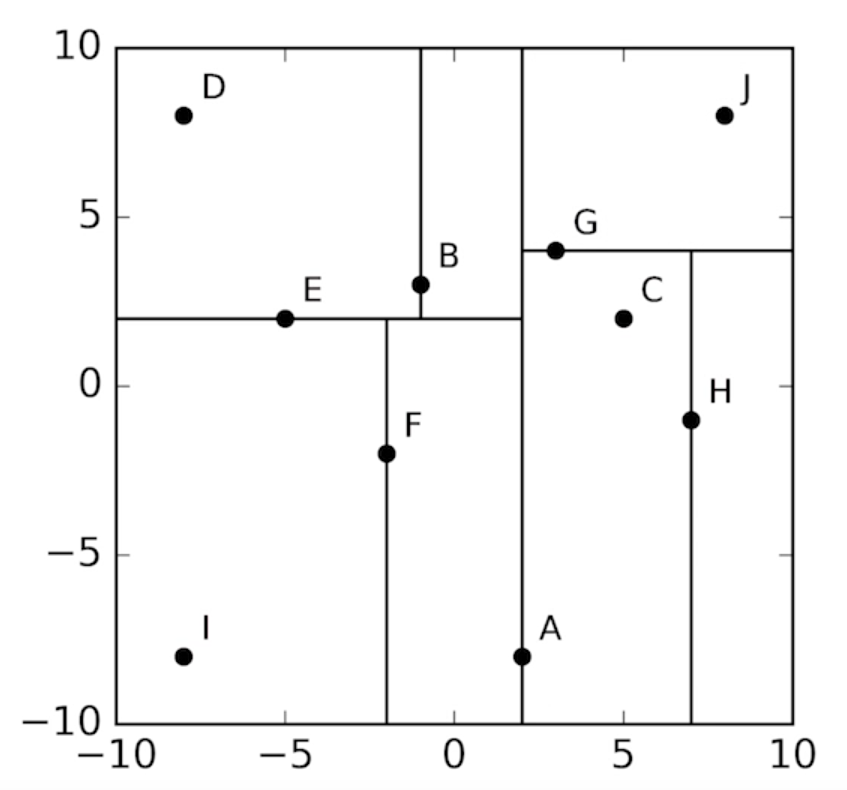

Astropy constructs a k-d tree out of the second catalogue, letting it search through for a match for each object in the first catalogue efficiently. Constructing a k-d tree is similar to the binary search you saw earlier. The k-dimensional space is divided into two parts recursively until each division only contains only a single object. Creating a k-d tree from an astronomy catalogue works like this:

1. Find the object with the median right ascension, split the catalogue into objects left and right partitions of this
2. Find the objects with the median declination in each partition, split the partitions into smaller partitions of objects down and up of these
3. Find the objects with median right ascension in each of the partitions, split the partitions into smaller partitions of objects left and right of these
4. Repeat 2-3 until each partition only has one object in it

This creates a binary tree where each object used to split a partition (a node) links to the two objects that then split the partitions it has created (its children).

# Searching k-d trees

Once you've made a k-d tree out of a catalogue, finding a match to an object then works like this:

1. Calculate the distance from the object to highest level node (the root node), then go to the child node closest (in right ascension) to the object
2. Calculate the distance from the object to this child, then go to the child node closest (in declination) to the object
3. Calculate the distance from the object to this child, then go to the child node closest (in right ascension) to the object
4. Repeat 2-3 until you reach a child node with no further children (a leaf node)
5. Find the shortest distance of all distances calculated, this corresponds to the closest object
Since each node branches into two children, a catalogue of $N$ objects will have, on average, $\log_2(N)$ nodes from the root to any leaf. So while it seems like a lot of effort to create a k-d tree, doing so lets you, for example, search the entire SuperCOSMOS catalogue of 250 million objects using only 28 distance calculations.

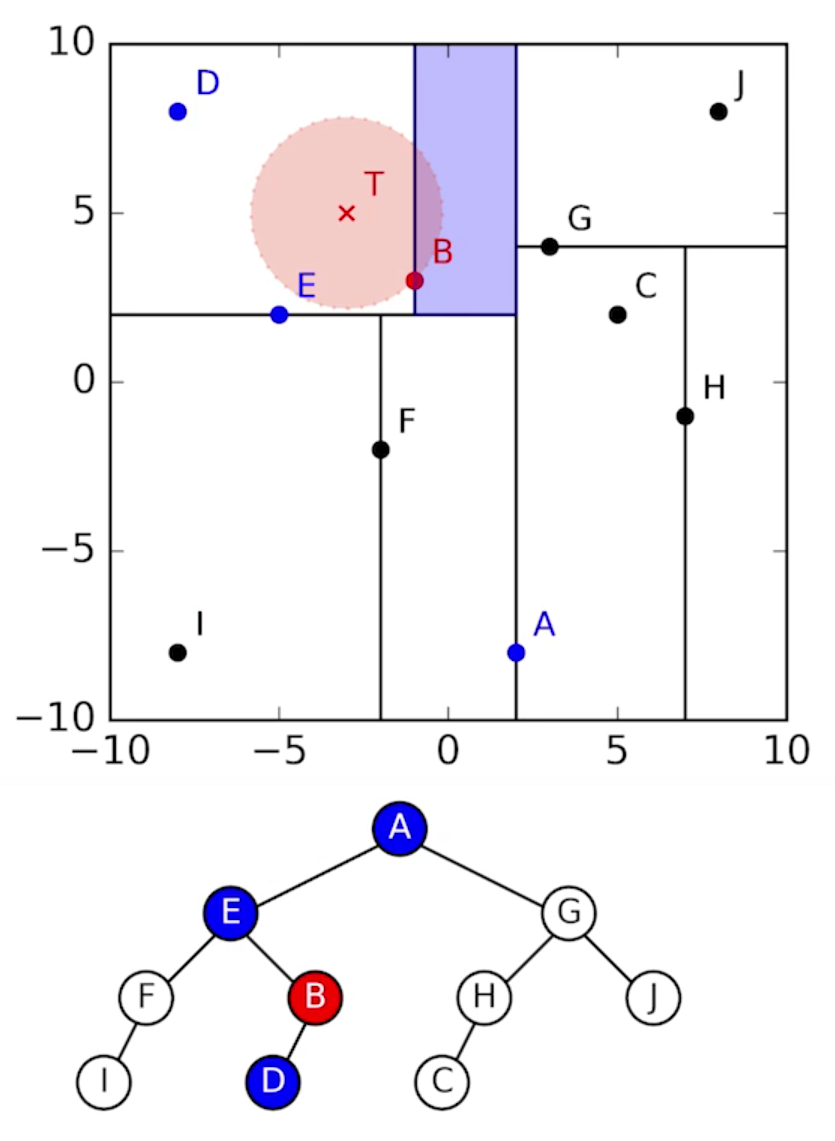

# Crossmatching in Astropy

Here's an example of using Astropy to crossmatch two catalogues with 2 objects each:

In [10]:
from astropy.coordinates import SkyCoord
from astropy import units as u
coords1 = [[270, -30], [185, 15]]
coords2 = [[185, 20], [280, -30]]
sky_cat1 = SkyCoord(coords1*u.degree, frame='icrs')
sky_cat2 = SkyCoord(coords2*u.degree, frame='icrs')
closest_ids, closest_dists, closest_dists3d = sky_cat1.match_to_catalog_sky(sky_cat2)
print(closest_ids)
print(closest_dists)

[1 0]
[8d39m27.00009472s 5d00m00s]


The SkyCoord objects are general purpose sky catalogue storage and manipulation objects in Astropy. They take anything that looks like an array of coordinates as long as you specify the units (here we specify degrees with u.degree) and a reference frame (ICRS [link text](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_its_realizations) is essentially the same as equatorial coordinates. The outputs, closest_id and closest_dists give the matching object's row index in sky_cat2 and the distance to it. closest_dists is the angular distance while closest_dists3d is the 3D distance which we're not concerned with here.

# **Hint**:
Astropy returns distances as Quantity objects. You can convert these to NumPy arrays by accessing their value attribute like this:

In [ ]:
closest_dists_array = closest_dists.value

# **Question: Space trees**

Copy your crossmatch solution from Microoptimisation and (substantially!) modify it to use Astropy to perform the matching.

The return values should behave the same way as the original function, given the same arguments, except time_taken should be noticeably smaller for large catalogues.

We will test your function on random input arrays. We've included the function create_cat in the starting file to generate random arrays so you can test your function yourself.

# **Hint**:
Astropy doesn't let you specify a maximum radius, so you'll have to weed out matches with distances greater than 5 degrees yourself.

# ⌛Solution:

In [11]:
# Write your crossmatch function here.
import numpy as np
import time

def angular_dist(r1, d1, r2, d2):
  a = (np.sin(np.abs(d1 - d2)/2))**2
  b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
  d = 2*np.arcsin(np.sqrt(a + b))
  return d

def crossmatch(cat1, cat2, max_dist):
    max_dist = np.radians(max_dist)
    matches = []
    no_matches = []

    start = time.perf_counter()

    cat1 = np.radians(cat1)
    cat2 = np.radians(cat2)
    sorted_indexes = np.argsort(cat2[:, 1])

    id_1 = 0
    for i in cat1:
        best = (0, 0, max_dist+1)
        id_2 = 0
        for j in sorted_indexes:
          if(cat2[j][1] > max_dist + i[1]):
            break
          dist = angular_dist(i[0], i[1], cat2[j][0], cat2[j][1])
          if dist <= best[2]:
            best = (id_1, j, dist)
          id_2 += 1
        if best[2] <= max_dist:
          matches.append(best)
        else:
          no_matches.append(id_1)
        id_1 += 1

    time_taken = time.perf_counter() - start
    return matches, no_matches, time_taken


# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
  # The example in the question
  cat1 = np.array([[180, 30], [45, 10], [300, -45]])
  cat2 = np.array([[180, 32], [55, 10], [302, -44]])
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

  # A function to create a random catalogue of size n
  def create_cat(n):
    ras = np.random.uniform(0, 360, size=(n, 1))
    decs = np.random.uniform(-90, 90, size=(n, 1))
    return np.hstack((ras, decs))

  # Test your function on random inputs
  np.random.seed(0)
  cat1 = create_cat(10)
  cat2 = create_cat(20)
  matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
  print('matches:', matches)
  print('unmatched:', no_matches)
  print('time taken:', time_taken)

matches: [(0, 0, 0.03490658503988664), (2, 2, 0.03040382589186957)]
unmatched: [1]
time taken: 0.00024445100007142173
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.002898093000112567
